## Final Project Submission

Please fill out:
* Student name: Daniel Quillao
* Student pace: self paced
* Scheduled project review date/time: TBD
* Instructor name: Jeff Herman
* Blog post URL:


# 1. Import libraries

In [594]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

# 2. Obtain Data

In [595]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


# 3. Scrub and Clean Data

### Check Data Types

In [596]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [597]:
# Preview the 5 most frequent entries from each column
for col in df.columns:
    try:
        print(col, df[col].value_counts()[:5])
    except:
        print(col, df[col].value_counts())
        # If there aren't 5+ unique values for a column the first print statement
        # will throw an error for an invalid idx slice
    print('\n') # Break up the output between columns

id 795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
Name: id, dtype: int64


date 6/23/2014    142
6/26/2014    131
6/25/2014    131
7/8/2014     127
4/27/2015    126
Name: date, dtype: int64


price 350000.0    172
450000.0    172
550000.0    159
500000.0    152
425000.0    150
           ... 
870515.0      1
336950.0      1
386100.0      1
176250.0      1
884744.0      1
Name: price, Length: 3622, dtype: int64


bedrooms 3    9824
4    6882
2    2760
5    1601
6     272
Name: bedrooms, dtype: int64


bathrooms 2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
Name: bathrooms, dtype: int64


sqft_living 1300    138
1400    135
1440    133
1660    129
1010    129
Name: sqft_living, dtype: int64


sqft_lot 5000    358
6000    290
4000    251
7200    220
7500    119
Name: sqft_lot, dtype: 

### Check for Erroneous Values (i.e. ?)

In [598]:
# sqft_basement includes 454 instances of '?'
sum(df['sqft_basement'] =='?')

454

In [599]:
# Verify that instances are dropped
sum(df['sqft_basement'] =='?')

454

In [600]:
# Drop rows as it only accounts for 2% of the data
df = df.drop(df[df['sqft_basement']=='?'].index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21143 non-null  int64  
 1   date           21143 non-null  object 
 2   price          21143 non-null  float64
 3   bedrooms       21143 non-null  int64  
 4   bathrooms      21143 non-null  float64
 5   sqft_living    21143 non-null  int64  
 6   sqft_lot       21143 non-null  int64  
 7   floors         21143 non-null  float64
 8   waterfront     18804 non-null  float64
 9   view           21082 non-null  float64
 10  condition      21143 non-null  int64  
 11  grade          21143 non-null  int64  
 12  sqft_above     21143 non-null  int64  
 13  sqft_basement  21143 non-null  object 
 14  yr_built       21143 non-null  int64  
 15  yr_renovated   17389 non-null  float64
 16  zipcode        21143 non-null  int64  
 17  lat            21143 non-null  float64
 18  long  

### Check for Null Values

In [601]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2339
view               61
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3754
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [602]:
# Check waterfront
df['waterfront'].value_counts()

0.0    18662
1.0      142
Name: waterfront, dtype: int64

In [603]:
# Fill NaNs with mode (which is 0, the majority of the data)
df['waterfront'].fillna(df['waterfront'].mode(), inplace = True)

In [604]:
# Double-check waterfront
df['waterfront'].isna().sum()

2338

In [605]:
# Check view
df['view'].value_counts()

0.0    19018
2.0      930
3.0      496
1.0      327
4.0      311
Name: view, dtype: int64

In [606]:
# Drop NaNs (61, small percentage of data)
df.dropna(subset = ['view'], inplace = True)

In [607]:
# Double-check view
df['view'].isna().sum()

0

In [608]:
# Check yr_renovated
df['yr_renovated'].value_counts()

0.0       16618
2014.0       69
2003.0       31
2013.0       31
2007.0       30
          ...  
1953.0        1
1944.0        1
1934.0        1
1971.0        1
1959.0        1
Name: yr_renovated, Length: 69, dtype: int64

In [609]:
# Drop yr_renovated column (large percentage is either 0 (16618) or NaNs (3754))
df.drop('yr_renovated', axis = 1, inplace = True)

In [610]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21082 non-null  int64  
 1   date           21082 non-null  object 
 2   price          21082 non-null  float64
 3   bedrooms       21082 non-null  int64  
 4   bathrooms      21082 non-null  float64
 5   sqft_living    21082 non-null  int64  
 6   sqft_lot       21082 non-null  int64  
 7   floors         21082 non-null  float64
 8   waterfront     18750 non-null  float64
 9   view           21082 non-null  float64
 10  condition      21082 non-null  int64  
 11  grade          21082 non-null  int64  
 12  sqft_above     21082 non-null  int64  
 13  sqft_basement  21082 non-null  object 
 14  yr_built       21082 non-null  int64  
 15  zipcode        21082 non-null  int64  
 16  lat            21082 non-null  float64
 17  long           21082 non-null  float64
 18  sqft_l

### Numeric Data Encoded as Strings
- sqft_basement

In [611]:
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'])

In [612]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21082 non-null  int64  
 1   date           21082 non-null  object 
 2   price          21082 non-null  float64
 3   bedrooms       21082 non-null  int64  
 4   bathrooms      21082 non-null  float64
 5   sqft_living    21082 non-null  int64  
 6   sqft_lot       21082 non-null  int64  
 7   floors         21082 non-null  float64
 8   waterfront     18750 non-null  float64
 9   view           21082 non-null  float64
 10  condition      21082 non-null  int64  
 11  grade          21082 non-null  int64  
 12  sqft_above     21082 non-null  int64  
 13  sqft_basement  21082 non-null  float64
 14  yr_built       21082 non-null  int64  
 15  zipcode        21082 non-null  int64  
 16  lat            21082 non-null  float64
 17  long           21082 non-null  float64
 18  sqft_l

### Categorical Data Encoded as Integers
- waterfront, view, zipcode, condition, and grade

In [613]:
convert_to_str = ['waterfront', 'view', 'zipcode', 'condition', 'grade']

for col in convert_to_str:
    df[col] = df[col].astype('str')        

In [614]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21082 non-null  int64  
 1   date           21082 non-null  object 
 2   price          21082 non-null  float64
 3   bedrooms       21082 non-null  int64  
 4   bathrooms      21082 non-null  float64
 5   sqft_living    21082 non-null  int64  
 6   sqft_lot       21082 non-null  int64  
 7   floors         21082 non-null  float64
 8   waterfront     21082 non-null  object 
 9   view           21082 non-null  object 
 10  condition      21082 non-null  object 
 11  grade          21082 non-null  object 
 12  sqft_above     21082 non-null  int64  
 13  sqft_basement  21082 non-null  float64
 14  yr_built       21082 non-null  int64  
 15  zipcode        21082 non-null  object 
 16  lat            21082 non-null  float64
 17  long           21082 non-null  float64
 18  sqft_l

## Get rid of unecessary features

In [615]:
df.drop(columns=['id', 'date'], inplace=True) 

In [616]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21082 non-null  float64
 1   bedrooms       21082 non-null  int64  
 2   bathrooms      21082 non-null  float64
 3   sqft_living    21082 non-null  int64  
 4   sqft_lot       21082 non-null  int64  
 5   floors         21082 non-null  float64
 6   waterfront     21082 non-null  object 
 7   view           21082 non-null  object 
 8   condition      21082 non-null  object 
 9   grade          21082 non-null  object 
 10  sqft_above     21082 non-null  int64  
 11  sqft_basement  21082 non-null  float64
 12  yr_built       21082 non-null  int64  
 13  zipcode        21082 non-null  object 
 14  lat            21082 non-null  float64
 15  long           21082 non-null  float64
 16  sqft_living15  21082 non-null  int64  
 17  sqft_lot15     21082 non-null  int64  
dtypes: flo

## Explore Data

In [617]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15
count,2.108200e+04,21082.000000,21082.000000,21082.000000,2.108200e+04,21082.00000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000
mean,5.402469e+05,3.372403,2.115916,2080.359975,1.507759e+04,1.49362,1789.000000,291.359975,1971.023337,47.560371,-122.213843,1986.917418,12732.514135
std,3.667323e+05,0.924996,0.768142,917.856396,4.117338e+04,0.53937,828.369355,442.007858,29.323120,0.138568,0.140607,685.544250,27148.781580
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.00000,370.000000,0.000000,1900.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.00000,1200.000000,0.000000,1952.000000,47.471325,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.50000,1560.000000,0.000000,1975.000000,47.572200,-122.230000,1840.000000,7626.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.069775e+04,2.00000,2210.000000,560.000000,1997.000000,47.678200,-122.125000,2360.000000,10088.750000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.50000,9410.000000,4820.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000


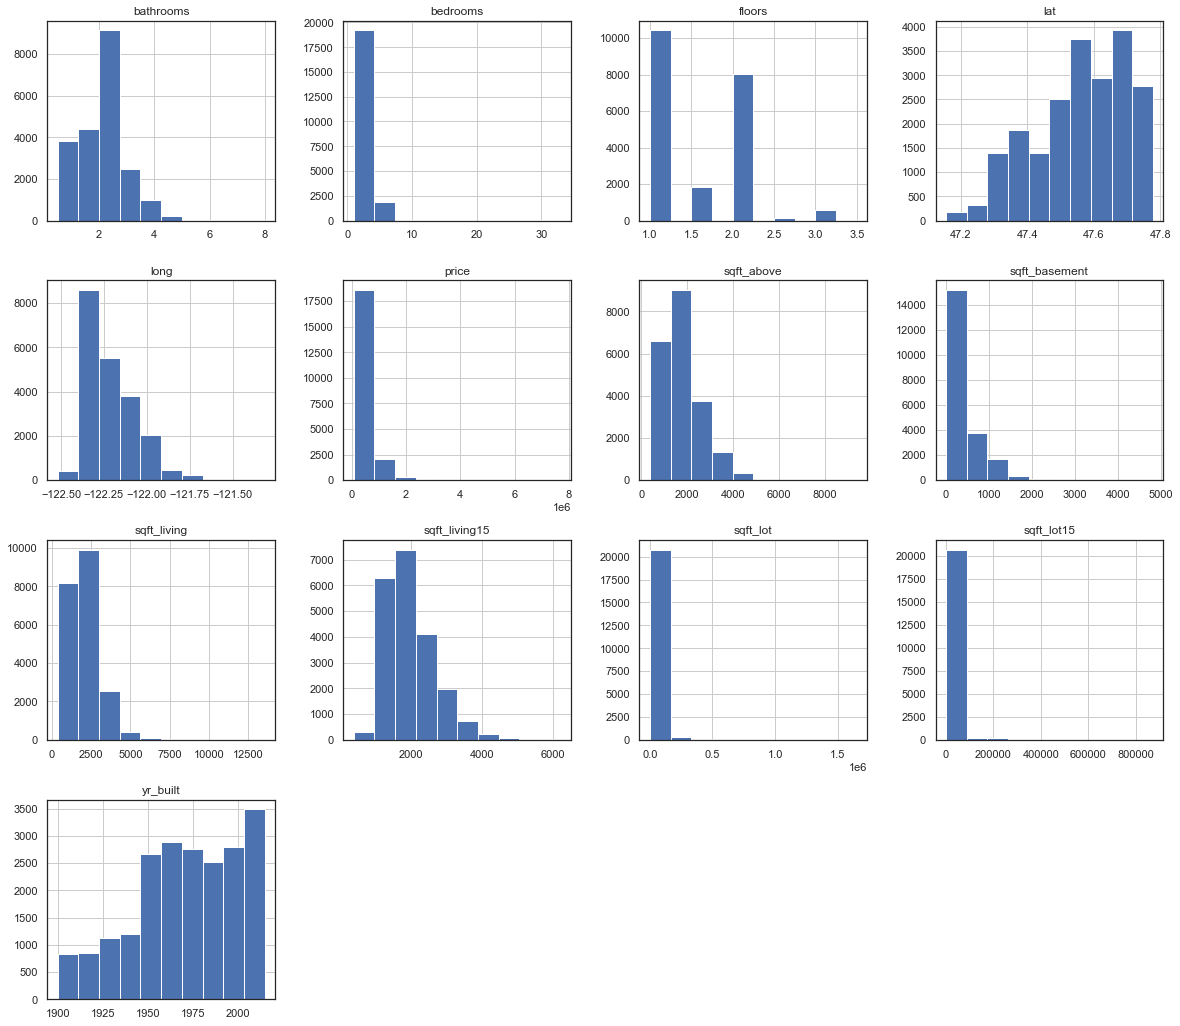

In [618]:
df.hist(figsize = (20,18));

### Check for Linearity

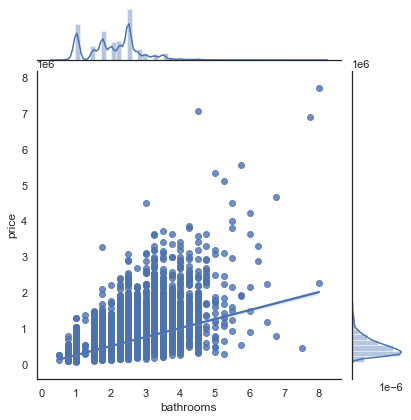

In [619]:
sns.jointplot('bathrooms','price', data=df, kind='reg');

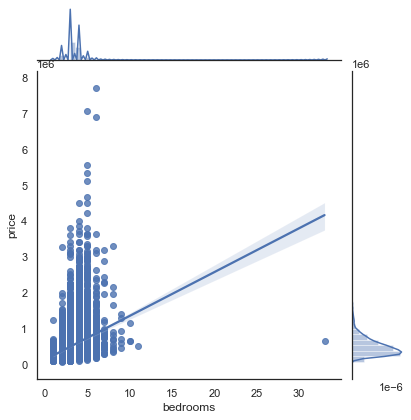

In [620]:
sns.jointplot('bedrooms','price', data=df, kind='reg');

Note how skewed most of these distributions are. While linear regression does not assume that each of the individual predictors are normally distributed, it does assume a linear relationship between the predictors and the target variable (list_price in this case). To further investigate if this assumption holds true, you can plot some single variable regression plots of each feature against the target variable using seaborn.

## Check for Multicollinearity

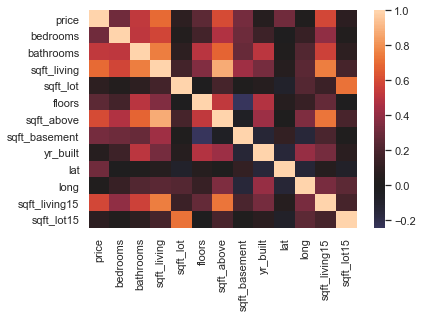

In [621]:
sns.heatmap(df.corr(), center=0);

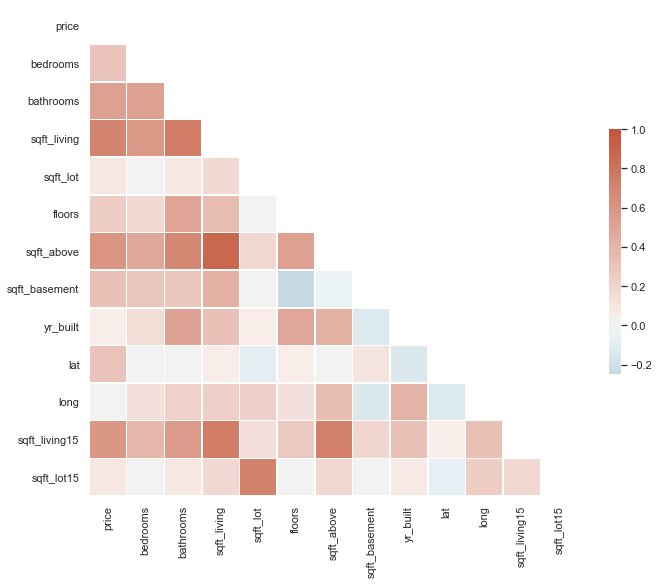

In [622]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [623]:
df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15
price,1.000000,0.308454,0.525029,0.702004,0.088400,0.256603,0.605481,0.323018,0.054849,0.307667,0.022512,0.586495,0.083530
bedrooms,0.308454,1.000000,0.513694,0.577696,0.032531,0.178518,0.478967,0.301987,0.156820,-0.009939,0.131398,0.391936,0.030779
bathrooms,0.525029,0.513694,1.000000,0.754793,0.088451,0.503796,0.685959,0.281813,0.508866,0.025243,0.224660,0.569396,0.089414
sqft_living,0.702004,0.577696,0.754793,1.000000,0.173266,0.354260,0.876787,0.433369,0.319584,0.053213,0.241473,0.756199,0.184920
sqft_lot,0.088400,0.032531,0.088451,0.173266,1.000000,-0.007745,0.183653,0.015612,0.052469,-0.085076,0.230489,0.143815,0.719499
floors,0.256603,0.178518,0.503796,0.354260,-0.007745,1.000000,0.523594,-0.245628,0.489898,0.049237,0.125360,0.279379,-0.011632
sqft_above,0.605481,0.478967,0.685959,0.876787,0.183653,0.523594,1.000000,-0.053403,0.425170,-0.000014,0.344774,0.730794,0.195983
sqft_basement,0.323018,0.301987,0.281813,0.433369,0.015612,-0.245628,-0.053403,1.000000,-0.133178,0.110526,-0.144709,0.200709,0.016705
yr_built,0.054849,0.156820,0.508866,0.319584,0.052469,0.489898,0.425170,-0.133178,1.000000,-0.148165,0.409009,0.325657,0.071184
lat,0.307667,-0.009939,0.025243,0.053213,-0.085076,0.049237,-0.000014,0.110526,-0.148165,1.000000,-0.135173,0.050357,-0.084799


In [624]:
abs(df.corr()) > 0.75

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15
price,True,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,True,False,False,False,False,False,False,False,False,False
sqft_living,False,False,True,True,False,False,True,False,False,False,False,True,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,True,False,False,False,False,False,False,False
sqft_above,False,False,False,True,False,False,True,False,False,False,False,False,False
sqft_basement,False,False,False,False,False,False,False,True,False,False,False,False,False
yr_built,False,False,False,False,False,False,False,False,True,False,False,False,False
lat,False,False,False,False,False,False,False,False,False,True,False,False,False


In [625]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df_abs = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df_abs['pairs'] = list(zip(df_abs.level_0, df_abs.level_1))

# set index to pairs
df_abs.set_index(['pairs'], inplace = True)

#d rop level columns
df_abs.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df_abs.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df_abs.drop_duplicates(inplace=True)

In [626]:
df_abs[(df_abs.cc>.75) & (df_abs.cc <1)]

,cc
pairs,
"(sqft_above, sqft_living)",0.876787
"(sqft_living, sqft_living15)",0.756199
"(sqft_living, bathrooms)",0.754793


In [627]:
# Drop sqft_living as it is highly correlated to sqft_above, sqft_living15, and bathrooms
df.drop('sqft_living', axis = 1, inplace = True)

In [628]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21082 non-null  float64
 1   bedrooms       21082 non-null  int64  
 2   bathrooms      21082 non-null  float64
 3   sqft_lot       21082 non-null  int64  
 4   floors         21082 non-null  float64
 5   waterfront     21082 non-null  object 
 6   view           21082 non-null  object 
 7   condition      21082 non-null  object 
 8   grade          21082 non-null  object 
 9   sqft_above     21082 non-null  int64  
 10  sqft_basement  21082 non-null  float64
 11  yr_built       21082 non-null  int64  
 12  zipcode        21082 non-null  object 
 13  lat            21082 non-null  float64
 14  long           21082 non-null  float64
 15  sqft_living15  21082 non-null  int64  
 16  sqft_lot15     21082 non-null  int64  
dtypes: float64(6), int64(6), object(5)
memory usage: 2

## Normalize Data

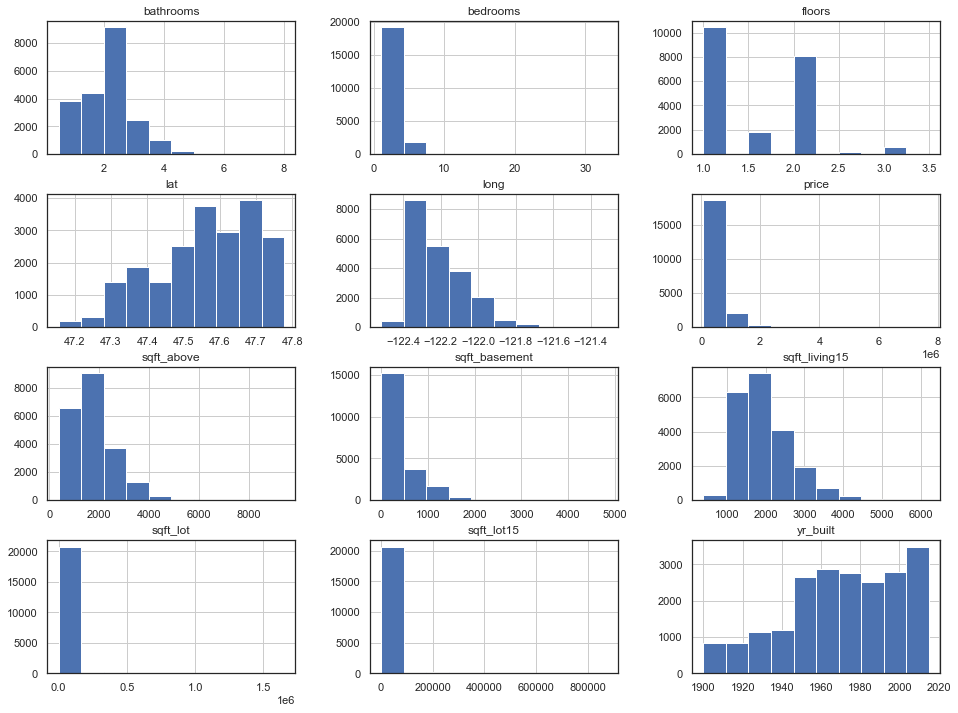

In [629]:
df.hist(figsize=(16,12));

In [630]:
# Log transform to reduce skewness
# Don't bother to normalize the price as this is the feature you will be predicting
cont_data = ['bathrooms', 'bedrooms', 'floors', 'lat','long', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'yr_built']
#for var in cont_data:
#    df[var]= np.log(df[var])
#df.describe()

In [631]:
# Standardize all continuous data to z-score
for item in cont_data:
    df[item] = (df[item] - df[item].mean()) / df[item].std()

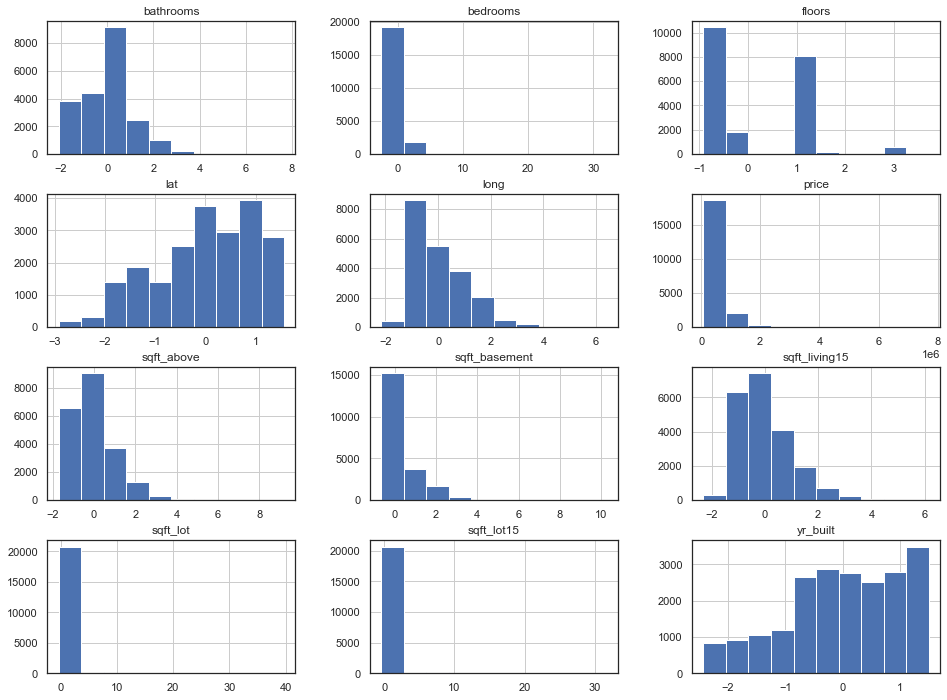

In [632]:
df.hist(figsize=(16,12));

In [633]:
# One-hot encode categorical data
df = pd.get_dummies(df) 
df.head()

,price,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,221900.0,-0.402600,-1.452748,-0.228973,-0.915179,-0.735179,-0.659174,-0.546440,-0.354849,-0.306933,...,0,0,0,0,0,0,1,0,0,0
1,538000.0,-0.402600,0.174556,-0.190307,0.938835,0.459940,0.245788,-0.682852,1.159208,-0.747879,...,0,0,0,0,0,0,0,0,0,0
2,180000.0,-1.483686,-1.452748,-0.123322,-0.915179,-1.230128,-0.659174,-1.296702,1.281170,-0.136245,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,0.678486,1.150938,-0.244760,-0.915179,-0.892114,1.399613,-0.205413,-0.285569,-1.274170,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,-0.402600,-0.150905,-0.169954,-0.915179,-0.131584,-0.659174,0.544849,0.407231,1.200818,...,0,0,0,0,0,0,0,0,0,0


In [634]:
df.describe()

,price,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
count,2.108200e+04,2.108200e+04,2.108200e+04,2.108200e+04,2.108200e+04,2.108200e+04,2.108200e+04,2.108200e+04,2.108200e+04,2.108200e+04,...,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000
mean,5.402469e+05,-1.910329e-15,-2.794484e-15,-2.950106e-16,-2.007930e-14,1.850863e-16,-5.826506e-15,8.573079e-16,3.342675e-13,-5.259425e-12,...,0.013187,0.002609,0.020634,0.011764,0.012380,0.011906,0.012238,0.006214,0.012807,0.014847
std,3.667323e+05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.114076,0.051012,0.142158,0.107823,0.110578,0.108465,0.109949,0.078584,0.112444,0.120942
min,7.800000e+04,-2.564772e+00,-2.103670e+00,-3.535680e-01,-9.151785e-01,-1.713004e+00,-6.591737e-01,-2.422093e+00,-2.918930e+00,-2.170286e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.220000e+05,-4.025997e-01,-4.763658e-01,-2.437883e-01,-9.151785e-01,-7.110355e-01,-6.591737e-01,-6.487487e-01,-6.426134e-01,-8.118877e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000e+05,-4.025997e-01,1.745558e-01,-1.811264e-01,1.182833e-02,-2.764467e-01,-6.591737e-01,1.356153e-01,8.536787e-02,-1.149085e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.450000e+05,6.784864e-01,5.000166e-01,-1.063755e-01,9.388352e-01,5.082274e-01,6.077721e-01,8.858765e-01,8.503345e-01,6.318550e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.700000e+06,3.202998e+01,7.660154e+00,3.974125e+01,3.719856e+00,9.200002e+00,1.024561e+01,1.499727e+00,1.567671e+00,6.392602e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 4. Explore Data

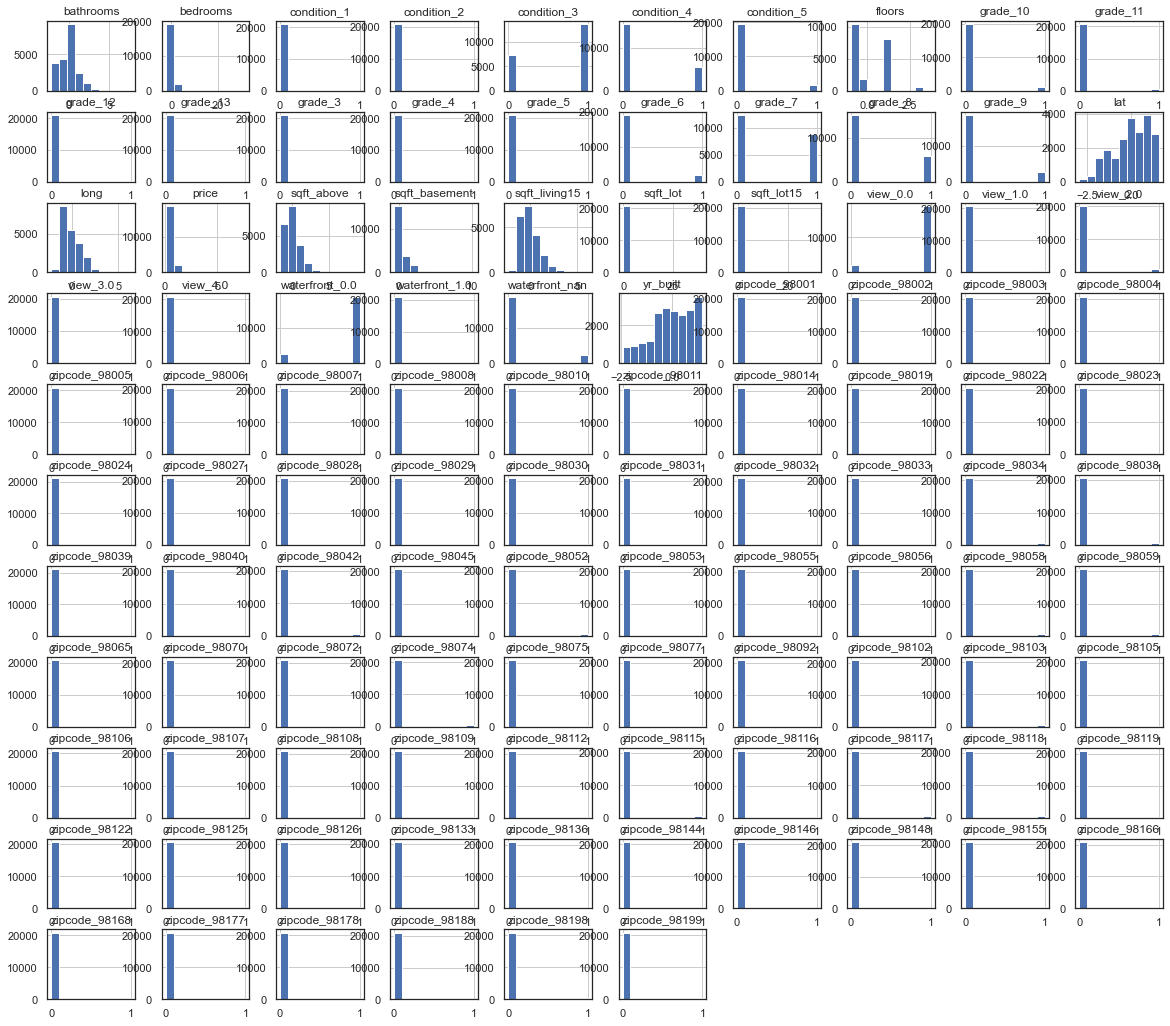

In [635]:
df.hist(figsize = (20,18));

## 5. Model

In [636]:
subs = [(' ', '_'),('.',''),("'",""),('™', ''), ('®',''),
        ('+','plus'), ('½','half'), ('-','_')
       ]
def col_formatting(col):
    for old, new in subs:
        col = col.replace(old,new)
    return col

In [637]:
df.columns = [col_formatting(col) for col in df.columns]

In [638]:
list(df.columns)

['price',
 'bedrooms',
 'bathrooms',
 'sqft_lot',
 'floors',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'waterfront_00',
 'waterfront_10',
 'waterfront_nan',
 'view_00',
 'view_10',
 'view_20',
 'view_30',
 'view_40',
 'condition_1',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13',
 'grade_3',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'zipcode_98001',
 'zipcode_98002',
 'zipcode_98003',
 'zipcode_98004',
 'zipcode_98005',
 'zipcode_98006',
 'zipcode_98007',
 'zipcode_98008',
 'zipcode_98010',
 'zipcode_98011',
 'zipcode_98014',
 'zipcode_98019',
 'zipcode_98022',
 'zipcode_98023',
 'zipcode_98024',
 'zipcode_98027',
 'zipcode_98028',
 'zipcode_98029',
 'zipcode_98030',
 'zipcode_98031',
 'zipcode_98032',
 'zipcode_98033',
 'zipcode_98034',
 'zipcode_98038',
 'zipcode_98039',
 'zipcode_98040',
 'zipcode_98042',
 'zipcode_98045',
 'zipcod

In [639]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Columns: 106 entries, price to zipcode_98199
dtypes: float64(12), uint8(94)
memory usage: 4.0 MB


In [640]:
# Defining the problem
outcome = 'price'
x_cols = list(df.columns)
x_cols.remove(outcome)

In [641]:
train, test = train_test_split(df)

In [642]:
print(len(train), len(test))
train.head()

15811 5271


,price,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
15853,257500.0,-2.564772,-1.452748,-0.219015,-0.915179,-1.302559,-0.659174,-1.876449,0.012480,-0.491846,...,0,0,0,0,0,0,0,0,0,0
21022,370000.0,-1.483686,-1.452748,-0.338680,0.938835,-1.218056,-0.659174,1.295110,0.231145,-0.577191,...,0,0,0,0,0,0,0,0,0,0
7568,505000.0,-1.483686,-1.452748,-0.243303,-0.915179,-1.181840,-0.659174,-1.023879,0.022583,-1.281282,...,0,0,0,0,0,0,0,0,0,0
13982,190000.0,-1.483686,0.500017,-0.324010,0.938835,-0.831755,-0.659174,1.192802,-0.797230,0.176685,...,0,0,0,0,0,0,0,0,0,0
14422,234000.0,0.678486,0.500017,-0.166627,-0.915179,-0.807611,0.924509,0.544849,-2.146025,-0.200253,...,0,0,0,0,0,0,0,0,0,0


In [643]:
test.head()

,price,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
8593,600000.0,-1.483686,0.500017,-0.004848,0.938835,0.870385,-0.659174,0.647157,1.386533,0.062892,...,0,0,0,0,0,0,0,0,0,0
4117,635000.0,0.678486,0.500017,-0.194509,0.938835,0.749666,-0.659174,0.749465,1.075495,-0.143357,...,0,0,0,0,0,0,0,0,0,0
13796,418000.0,-0.402600,-0.150905,-0.219744,0.011828,-0.457525,-0.659174,-1.399010,1.003328,-0.947016,...,0,0,0,0,0,0,0,0,0,0
16084,799900.0,0.678486,0.500017,-0.176755,0.938835,-0.252303,2.621311,0.681260,0.928275,0.126901,...,0,0,0,0,0,0,0,0,0,0
14134,667000.0,1.759572,-0.150905,-0.233345,-0.915179,-0.735179,0.969757,-1.399010,0.766621,-0.634087,...,0,0,0,0,0,0,0,0,0,0


In [644]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     801.3
Date:                Tue, 09 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:06:33   Log-Likelihood:            -2.1049e+05
No. Observations:               15811   AIC:                         4.212e+05
Df Residuals:                   15710   BIC:                         4.220e+05
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       6.375e+05   9432.119     67.589      0.000    6.19e+05    6.56e+05
bedrooms       -1.139e+04   1537.415     -7.408      0.000   -1.44e+04   -8375.000
bathrooms       1.986e+04   2156.174      9.210      0.000    1.56e+04    2.41e+04
sqft_lot        1.004e+04   1678.554      5.984      0.000    6753.955    1.33e+04
floors         -1.398e+04   1838.581     -7.601      0.000   -1.76e+04   -1.04e+04
sqft_above      1.326e+05   2800.127     47.341      0.000    1.27e+05    1.38e+05
sqft_basement   4.826e+04   1694.483     28.481      0.000    4.49e+04    5.16e+04
yr_built       -1.442e+04   1963.059     -7.344      0.000   -1.83e+04   -1.06e+04
lat             2.332e+04   9397.056      2.482      0.013    4905.261    4.17e+04
long           -2.231e+04   6720.038     -3.320      0.001   -3.55e+04   -9139.020
sqft_living15   1.434e+04   2144.247      6.688      0.000    1.01e+04    1.85e+04
sqft_lot15     -1695.0426   1838.935     -0.922      0.357   -5299.566    1909.481
waterfront_00   7885.4939   6048.695      1.304      0.192   -3970.643    1.97e+04
waterfront_10   6.207e+05   1.31e+04     47.557      0.000    5.95e+05    6.46e+05
waterfront_nan  8945.2714   6404.768      1.397      0.163   -3608.810    2.15e+04
view_00         4691.6715   4406.739      1.065      0.287   -3946.044    1.33e+04
view_10         8.204e+04   8513.122      9.637      0.000    6.54e+04    9.87e+04
view_20          7.46e+04   5985.016     12.465      0.000    6.29e+04    8.63e+04
view_30         1.645e+05   7259.081     22.662      0.000     1.5e+05    1.79e+05
view_40         3.117e+05   9685.319     32.179      0.000    2.93e+05    3.31e+05
condition_1     3.686e+04   2.61e+04      1.410      0.158   -1.44e+04    8.81e+04
condition_2     1.217e+05   1.24e+04      9.804      0.000    9.74e+04    1.46e+05
condition_3     1.301e+05   6674.340     19.488      0.000    1.17e+05    1.43e+05
condition_4       1.5e+05   6764.838     22.180      0.000    1.37e+05    1.63e+05
condition_5     1.988e+05   7344.751     27.068      0.000    1.84e+05    2.13e+05
grade_10       -8.841e+04   1.51e+04     -5.862      0.000   -1.18e+05   -5.88e+04
grade_11        1.063e+05   1.67e+04      6.350      0.000    7.35e+04    1.39e+05
grade_12        4.391e+05   2.39e+04     18.403      0.000    3.92e+05    4.86e+05
grade_13        2.043e+06   5.42e+04     37.694      0.000    1.94e+06    2.15e+06
grade_3        -1.695e+05   1.35e+05     -1.256      0.209   -4.34e+05    9.49e+04
grade_4        -2.596e+05   3.24e+04     -8.018      0.000   -3.23e+05   -1.96e+05
grade_5        -3.255e+05   1.78e+04    -18.274      0.000    -3.6e+05   -2.91e+05
grade_6        -3.141e+05   1.51e+04    -20.784      0.000   -3.44e+05   -2.84e+05
grade_7        -3.065e+05   1.45e+04    -21.101      0.000   -3.35e+05   -2.78e+05
grade_8     

## Remove the Uninfluential Features

In [645]:
# Extract the p-value table from the summary and use it to subset our features
summary = model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
x_cols.remove('Intercept')
print(len(p_table), len(x_cols))
print(x_cols[:5])
p_table.head()

106 88
['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'sqft_above']


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,6.375e+05,9432.119,67.589,0.0,6.19e+05,6.56e+05
bedrooms,-1.139e+04,1537.415,-7.408,0.0,-1.44e+04,-8375.000
bathrooms,1.986e+04,2156.174,9.210,0.0,1.56e+04,2.41e+04
sqft_lot,1.004e+04,1678.554,5.984,0.0,6753.955,1.33e+04
floors,-1.398e+04,1838.581,-7.601,0.0,-1.76e+04,-1.04e+04


In [646]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     908.8
Date:                Tue, 09 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:06:34   Log-Likelihood:            -2.1051e+05
No. Observations:               15811   AIC:                         4.212e+05
Df Residuals:                   15722   BIC:                         4.219e+05
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.056e+05   1.51e+05      3.348      0.001     2.1e+05    8.02e+05
bedrooms       -1.16e+04   1531.655     -7.576      0.000   -1.46e+04   -8601.447
bathrooms      1.982e+04   2155.843      9.192      0.000    1.56e+04     2.4e+04
sqft_lot       9490.6125   1313.351      7.226      0.000    6916.294    1.21e+04
floors        -1.449e+04   1832.390     -7.908      0.000   -1.81e+04   -1.09e+04
sqft_above      1.33e+05   2787.164     47.703      0.000    1.27e+05    1.38e+05
sqft_basement   4.81e+04   1691.221     28.438      0.000    4.48e+04    5.14e+04
yr_built       -1.39e+04   1952.323     -7.121      0.000   -1.77e+04   -1.01e+04
lat            2.591e+04   4783.003      5.418      0.000    1.65e+04    3.53e+04
long          -1.788e+04   2578.833     -6.934      0.000   -2.29e+04   -1.28e+04
sqft_living15  1.459e+04   2101.125      6.946      0.000    1.05e+04    1.87e+04
waterfront_10  6.156e+05   1.77e+04     34.715      0.000    5.81e+05     6.5e+05
view_10        7.642e+04   9641.609      7.926      0.000    5.75e+04    9.53e+04
view_20        6.767e+04   5975.721     11.324      0.000     5.6e+04    7.94e+04
view_30        1.579e+05   8173.580     19.322      0.000    1.42e+05    1.74e+05
view_40        3.036e+05    1.2e+04     25.212      0.000     2.8e+05    3.27e+05
condition_2    8.517e+04   3.42e+04      2.490      0.013    1.81e+04    1.52e+05
condition_3    9.411e+04   3.17e+04      2.965      0.003    3.19e+04    1.56e+05
condition_4    1.145e+05   3.18e+04      3.605      0.000    5.22e+04    1.77e+05
condition_5    1.633e+05    3.2e+04      5.110      0.000    1.01e+05    2.26e+05
grade_10       8.247e+04   1.48e+05      0.558      0.577   -2.07e+05    3.72e+05
grade_11       2.769e+05   1.48e+05      1.870      0.062   -1.34e+04    5.67e+05
grade_12       6.078e+05   1.49e+05      4.068      0.000    3.15e+05    9.01e+05
grade_13       2.211e+06   1.59e+05     13.923      0.000     1.9e+06    2.52e+06
grade_4       -8.874e+04   1.51e+05     -0.588      0.556   -3.84e+05    2.07e+05
grade_5       -1.579e+05   1.48e+05     -1.068      0.286   -4.48e+05    1.32e+05
grade_6       -1.458e+05   1.48e+05     -0.988      0.323   -4.35e+05    1.43e+05
grade_7       -1.385e+05   1.48e+05     -0.938      0.348   -4.28e+05    1.51e+05
grade_8       -1.106e+05   1.48e+05     -0.749      0.454      -4e+05    1.79e+05
grade_9       -3.803e+04   1.48e+05     -0.257      0.797   -3.28e+05    2.51e+05
zipcode_98001 -1.371e+05   1.58e+04     -8.668      0.000   -1.68e+05   -1.06e+05
zipcode_98002 -1.178e+05   1.71e+04     -6.895      0.000   -1.51e+05   -8.43e+04
zipcode_98003 -1.506e+05   1.67e+04     -9.028      0.000   -1.83e+05   -1.18e+05
zipcode_98004  5.841e+05   1.05e+04     55.864      0.000    5.64e+05    6.05e+05
zipcode_98005   1.28e+05   1.36e+04      9.385   

Comment: You should see that the model performance is identical. Additionally, observe that there are further features which have been identified as unimpactful. Continue to refine the model accordingly.

In [647]:
# Extract the p-value table from the summary and use it to subset our features
summary = model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
x_cols.remove('Intercept')
print(len(p_table), len(x_cols))
print(x_cols[:5])
p_table.head()

89 80
['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'sqft_above']


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,5.056e+05,1.51e+05,3.348,0.001,2.1e+05,8.02e+05
bedrooms,-1.16e+04,1531.655,-7.576,0.000,-1.46e+04,-8601.447
bathrooms,1.982e+04,2155.843,9.192,0.000,1.56e+04,2.4e+04
sqft_lot,9490.6125,1313.351,7.226,0.000,6916.294,1.21e+04
floors,-1.449e+04,1832.390,-7.908,0.000,-1.81e+04,-1.09e+04


In [648]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     886.0
Date:                Tue, 09 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:06:34   Log-Likelihood:            -2.1130e+05
No. Observations:               15811   AIC:                         4.228e+05
Df Residuals:                   15730   BIC:                         4.234e+05
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.018e+05   3.34e+04     12.017      0.000    3.36e+05    4.67e+05
bedrooms      -2.315e+04   1574.904    -14.699      0.000   -2.62e+04   -2.01e+04
bathrooms      2.113e+04   2251.184      9.385      0.000    1.67e+04    2.55e+04
sqft_lot       1.125e+04   1378.840      8.158      0.000    8546.384     1.4e+04
floors        -1.799e+04   1905.069     -9.445      0.000   -2.17e+04   -1.43e+04
sqft_above     1.802e+05   2622.928     68.691      0.000    1.75e+05    1.85e+05
sqft_basement  5.684e+04   1756.023     32.370      0.000    5.34e+04    6.03e+04
yr_built      -5594.3042   1944.448     -2.877      0.004   -9405.646   -1782.962
lat            2.256e+04   5022.568      4.491      0.000    1.27e+04    3.24e+04
long          -2.477e+04   2696.484     -9.188      0.000   -3.01e+04   -1.95e+04
sqft_living15   3.15e+04   2122.019     14.843      0.000    2.73e+04    3.57e+04
waterfront_10  6.272e+05   1.86e+04     33.699      0.000    5.91e+05    6.64e+05
view_10        7.732e+04   1.01e+04      7.632      0.000    5.75e+04    9.72e+04
view_20        7.272e+04   6270.792     11.596      0.000    6.04e+04     8.5e+04
view_30        1.735e+05   8576.108     20.231      0.000    1.57e+05     1.9e+05
view_40        3.329e+05   1.26e+04     26.361      0.000    3.08e+05    3.58e+05
condition_2    9.686e+04   3.59e+04      2.702      0.007    2.66e+04    1.67e+05
condition_3    1.016e+05   3.32e+04      3.063      0.002    3.66e+04    1.67e+05
condition_4    1.189e+05   3.32e+04      3.585      0.000    5.39e+04    1.84e+05
condition_5    1.681e+05   3.34e+04      5.036      0.000    1.03e+05    2.34e+05
grade_12       4.567e+05   2.15e+04     21.279      0.000    4.15e+05    4.99e+05
grade_13       1.965e+06   5.98e+04     32.850      0.000    1.85e+06    2.08e+06
zipcode_98001 -1.629e+05   1.66e+04     -9.818      0.000   -1.95e+05    -1.3e+05
zipcode_98002 -1.317e+05   1.79e+04     -7.352      0.000   -1.67e+05   -9.66e+04
zipcode_98003 -1.696e+05   1.75e+04     -9.682      0.000   -2.04e+05   -1.35e+05
zipcode_98004  6.023e+05    1.1e+04     54.856      0.000    5.81e+05    6.24e+05
zipcode_98005  1.376e+05   1.43e+04      9.619      0.000     1.1e+05    1.66e+05
zipcode_98006  9.126e+04   9255.865      9.860      0.000    7.31e+04    1.09e+05
zipcode_98007  7.603e+04   1.52e+04      4.987      0.000    4.61e+04    1.06e+05
zipcode_98008  8.877e+04   1.12e+04      7.900      0.000    6.67e+04    1.11e+05
zipcode_98010 -6.042e+04   2.05e+04     -2.943      0.003   -1.01e+05   -2.02e+04
zipcode_98011 -9.335e+04   1.37e+04     -6.808      0.000    -1.2e+05   -6.65e+04
zipcode_98014 -6.339e+04   1.71e+04     -3.717      0.000   -9.68e+04      -3e+04
zipcode_98019 -1.042e+05   1.45e+04     -7.166      0.000   -1.33e+05   -7.57e+04
zipcode_98022 -1.154e+05   1.89e+04     -6.107   

## 6. Investigate Multicollinearity

There are still a lot of features in the current model! Chances are there are some strong multicollinearity issues. Begin to investigate the extent of this problem.

In [649]:
X = df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('bedrooms', 1.6771189973151663),
 ('bathrooms', 3.360932672892431),
 ('sqft_lot', 1.204159894537772),
 ('floors', 2.4181075984221914),
 ('sqft_above', 4.47598779844169),
 ('sqft_basement', 2.014134223954744),
 ('yr_built', 2.5308956240442075),
 ('lat', 16.34206083076114),
 ('long', 4.806228990219164),
 ('sqft_living15', 2.9535844357595513),
 ('waterfront_10', 1.5393877993564804),
 ('view_10', 1.0702022054066778),
 ('view_20', 1.1431047588876018),
 ('view_30', 1.1406421046894772),
 ('view_40', 1.609904091140336),
 ('condition_2', 1.1218743962826272),
 ('condition_3', 9.722261872910234),
 ('condition_4', 4.699383954707047),
 ('condition_5', 2.1603621783114253),
 ('grade_12', 1.1012542619506513),
 ('grade_13', 1.0484868047277094),
 ('zipcode_98001', 2.9782723328886673),
 ('zipcode_98002', 2.0043703499417758),
 ('zipcode_98003', 2.5972251308380074),
 ('zipcode_98004', 1.148008128108902),
 ('zipcode_98005', 1.0717732038229453),
 ('zipcode_98006', 1.301809682081193),
 ('zipcode_98007', 1.0

## Perform Another Round of Feature Selection

In [650]:
# Once again, subset your features based on your findings above. Then rerun the model once again.
vif_scores = list(zip(x_cols, vif))
x_cols = [x for x,vif in vif_scores if vif < 5]
print(len(vif_scores), len(x_cols))

80 78


In [651]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     906.7
Date:                Tue, 09 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:06:40   Log-Likelihood:            -2.1132e+05
No. Observations:               15811   AIC:                         4.228e+05
Df Residuals:                   15732   BIC:                         4.234e+05
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.177e+05   3548.955    145.888      0.000    5.11e+05    5.25e+05
bedrooms      -2.302e+04   1576.065    -14.604      0.000   -2.61e+04   -1.99e+04
bathrooms      2.112e+04   2253.160      9.375      0.000    1.67e+04    2.55e+04
sqft_lot       1.113e+04   1379.772      8.069      0.000    8429.508    1.38e+04
floors        -1.888e+04   1897.061     -9.954      0.000   -2.26e+04   -1.52e+04
sqft_above     1.808e+05   2622.966     68.915      0.000    1.76e+05    1.86e+05
sqft_basement  5.671e+04   1756.483     32.285      0.000    5.33e+04    6.02e+04
yr_built      -4831.0547   1940.987     -2.489      0.013   -8635.612   -1026.498
long          -3.111e+04   2309.698    -13.468      0.000   -3.56e+04   -2.66e+04
sqft_living15  3.163e+04   2122.006     14.906      0.000    2.75e+04    3.58e+04
waterfront_10  6.258e+05   1.86e+04     33.600      0.000    5.89e+05    6.62e+05
view_10        7.675e+04   1.01e+04      7.570      0.000    5.69e+04    9.66e+04
view_20        7.174e+04   6271.296     11.440      0.000    5.94e+04     8.4e+04
view_30        1.729e+05   8582.102     20.146      0.000    1.56e+05     1.9e+05
view_40        3.327e+05   1.26e+04     26.330      0.000    3.08e+05    3.58e+05
condition_2   -5118.8830   1.41e+04     -0.362      0.717   -3.28e+04    2.26e+04
condition_4    1.734e+04   3181.642      5.450      0.000    1.11e+04    2.36e+04
condition_5    6.654e+04   4995.935     13.318      0.000    5.67e+04    7.63e+04
grade_12        4.56e+05   2.15e+04     21.228      0.000    4.14e+05    4.98e+05
grade_13       1.962e+06   5.99e+04     32.782      0.000    1.84e+06    2.08e+06
zipcode_98001 -2.209e+05   1.05e+04    -21.134      0.000   -2.41e+05      -2e+05
zipcode_98002 -1.869e+05   1.31e+04    -14.312      0.000   -2.13e+05   -1.61e+05
zipcode_98003 -2.282e+05   1.17e+04    -19.453      0.000   -2.51e+05   -2.05e+05
zipcode_98004  5.964e+05   1.09e+04     54.606      0.000    5.75e+05    6.18e+05
zipcode_98005   1.33e+05   1.43e+04      9.309      0.000    1.05e+05    1.61e+05
zipcode_98006  7.838e+04   8851.826      8.854      0.000     6.1e+04    9.57e+04
zipcode_98007  7.285e+04   1.52e+04      4.779      0.000     4.3e+04    1.03e+05
zipcode_98008  8.722e+04   1.12e+04      7.758      0.000    6.52e+04    1.09e+05
zipcode_98010 -1.029e+05   1.82e+04     -5.650      0.000   -1.39e+05   -6.72e+04
zipcode_98011 -7.645e+04   1.32e+04     -5.813      0.000   -1.02e+05   -5.07e+04
zipcode_98014 -4.325e+04   1.65e+04     -2.623      0.009   -7.56e+04   -1.09e+04
zipcode_98019 -7.835e+04   1.34e+04     -5.856      0.000   -1.05e+05   -5.21e+04
zipcode_98022 -1.768e+05    1.3e+04    -13.588      0.000   -2.02e+05   -1.51e+05
zipcode_98023 -2.635e+05   9837.704    -26.786      0.000   -2.83e+05   -2.44e+05
zipcode_98028 -9.114e+04   1.15e+04     -7.928   

## Check the Normality Assumption

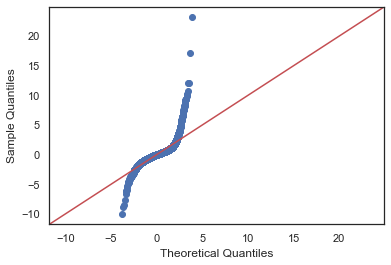

In [652]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

## Check Homoscedasticity Assumption

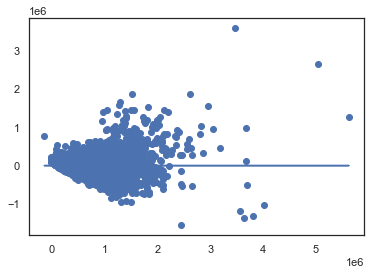

In [653]:
# Check whether the model's errors are indeed homoscedastic or if they violate this principle and display heteroscedasticity.
plt.scatter(model.predict(train[x_cols]), model.resid)
plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])

Comment: This displays a fairly pronounced 'funnel' shape: errors appear to increase as the list_price increases. This doesn't bode well for our model. Subsetting the data to remove outliers and confining the model to this restricted domain may be necessary. A log transformation or something equivalent may also be appropriate.

## Make Additional Refinements

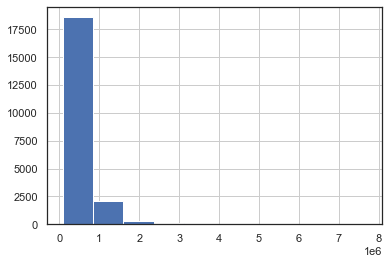

In [654]:
# From here, make additional refinements to your model based on the above analysis. As you progress, continue to go back and check the assumptions for the updated model. Be sure to attempt at least two additional model refinements.
#Comment: Based on the above plots, it seems as though outliers are having a substantial impact on the model. As such, removing outliers may be appropriate. Investigating the impact of a log transformation is also worthwhile.
df.price.hist();

In [655]:
for i in range(80,100):
    q = i/100
    print("{} percentile: {}".format(q, df.price.quantile(q=q)))

0.8 percentile: 702000.0
0.81 percentile: 719000.0
0.82 percentile: 732000.0
0.83 percentile: 750000.0
0.84 percentile: 762000.0
0.85 percentile: 780000.0
0.86 percentile: 799000.0
0.87 percentile: 815000.0
0.88 percentile: 838327.9999999999
0.89 percentile: 860000.0
0.9 percentile: 888999.0
0.91 percentile: 920000.0
0.92 percentile: 950000.0
0.93 percentile: 997966.5000000001
0.94 percentile: 1070000.0
0.95 percentile: 1160000.0
0.96 percentile: 1260000.0
0.97 percentile: 1390000.0
0.98 percentile: 1600000.0
0.99 percentile: 1970000.0


In [656]:
orig_tot = len(df)
df = df[df.price < 1300000] # Subsetting to remove extreme outliers
print('Percent removed:', (orig_tot -len(df))/orig_tot)
df.list_price = df.price.map(np.log) # Applying a log transformation
train, test = train_test_split(df)

# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

Percent removed: 0.037377857888245894


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     886.8
Date:                Tue, 09 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:06:41   Log-Likelihood:            -1.9632e+05
No. Observations:               15220   AIC:                         3.928e+05
Df Residuals:                   15142   BIC:                         3.934e+05
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.154e+05   2239.992    230.090      0.000    5.11e+05     5.2e+05
bedrooms      -9157.0235   1020.069     -8.977      0.000   -1.12e+04   -7157.565
bathrooms      1.293e+04   1478.986      8.741      0.000       1e+04    1.58e+04
sqft_lot       1.477e+04   1023.943     14.427      0.000    1.28e+04    1.68e+04
floors        -9746.3307   1234.648     -7.894      0.000   -1.22e+04   -7326.272
sqft_above     1.261e+05   1809.579     69.707      0.000    1.23e+05     1.3e+05
sqft_basement  3.723e+04   1189.323     31.303      0.000    3.49e+04    3.96e+04
yr_built      -1355.0508   1264.530     -1.072      0.284   -3833.682    1123.581
long          -2.126e+04   1455.450    -14.607      0.000   -2.41e+04   -1.84e+04
sqft_living15  4.133e+04   1443.728     28.630      0.000    3.85e+04    4.42e+04
waterfront_10  1.803e+05   1.56e+04     11.571      0.000     1.5e+05    2.11e+05
view_10        6.341e+04   6825.658      9.290      0.000       5e+04    7.68e+04
view_20        6.058e+04   4126.606     14.680      0.000    5.25e+04    6.87e+04
view_30        1.057e+05   6054.971     17.456      0.000    9.38e+04    1.18e+05
view_40        1.829e+05   9539.982     19.173      0.000    1.64e+05    2.02e+05
condition_2   -2.566e+04   8635.242     -2.972      0.003   -4.26e+04   -8738.065
condition_4    1.938e+04   2029.557      9.551      0.000    1.54e+04    2.34e+04
condition_5    5.637e+04   3247.801     17.357      0.000       5e+04    6.27e+04
grade_12      -4148.8096    3.7e+04     -0.112      0.911   -7.67e+04    6.84e+04
grade_13      -1.691e-10   4.34e-11     -3.891      0.000   -2.54e-10   -8.39e-11
zipcode_98001 -2.194e+05   6674.431    -32.873      0.000   -2.32e+05   -2.06e+05
zipcode_98002 -2.033e+05   8163.702    -24.898      0.000   -2.19e+05   -1.87e+05
zipcode_98003 -2.226e+05   7254.797    -30.689      0.000   -2.37e+05   -2.08e+05
zipcode_98004  3.335e+05   9020.616     36.971      0.000    3.16e+05    3.51e+05
zipcode_98005  1.527e+05   9223.128     16.554      0.000    1.35e+05    1.71e+05
zipcode_98006  9.566e+04   5720.514     16.723      0.000    8.44e+04    1.07e+05
zipcode_98007  7.856e+04   1.01e+04      7.804      0.000    5.88e+04    9.83e+04
zipcode_98008  5.796e+04   7109.847      8.152      0.000     4.4e+04    7.19e+04
zipcode_98010 -1.042e+05   1.14e+04     -9.158      0.000   -1.26e+05   -8.19e+04
zipcode_98011 -6.991e+04   8155.076     -8.573      0.000   -8.59e+04   -5.39e+04
zipcode_98014 -6.026e+04   1.07e+04     -5.620      0.000   -8.13e+04   -3.92e+04
zipcode_98019 -9.034e+04   8680.251    -10.408      0.000   -1.07e+05   -7.33e+04
zipcode_98022 -1.902e+05   7835.581    -24.273      0.000   -2.06e+05   -1.75e+05
zipcode_98023 -2.536e+05   6039.463    -41.989      0.000   -2.65e+05   -2.42e+05
zipcode_98028 -8.388e+04   7125.001    -11.772   

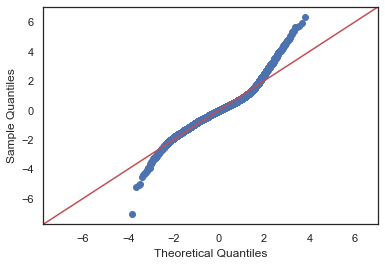

In [657]:
# Comment: This is much, much better!
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

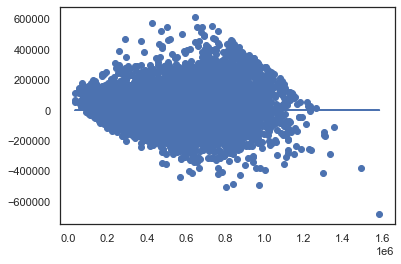

In [658]:
# Comment: There is still a clear underestimate now by the model as the log transformed 
# list price increases, but the model is much improved. Further subsetting is potentially warranted.
plt.scatter(model.predict(train[x_cols]), model.resid)
plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])

0.8 percentile: 665000.0
0.81 percentile: 677000.0
0.82 percentile: 690000.0
0.83 percentile: 700000.0
0.84 percentile: 716000.0
0.85 percentile: 730000.0
0.86 percentile: 745992.8199999998
0.87 percentile: 760000.0
0.88 percentile: 775000.0
0.89 percentile: 790000.0
0.9 percentile: 809665.0000000007
0.91 percentile: 829000.0
0.92 percentile: 850000.0
0.93 percentile: 875000.0
0.94 percentile: 900000.0
0.95 percentile: 932802.8
0.96 percentile: 970000.0
0.97 percentile: 1020000.0
0.98 percentile: 1100000.0
0.99 percentile: 1200000.0


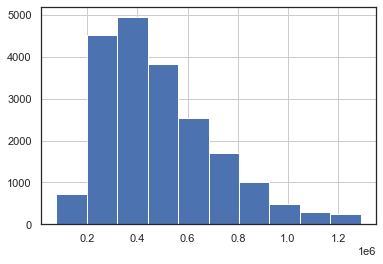

In [659]:
for i in range(80,100):
    q = i/100
    print("{} percentile: {}".format(q, df.price.quantile(q=q)))

df.price.hist()

In [662]:
df = df[df.price <= 1100000]
train, test = train_test_split(df)

# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     833.9
Date:                Tue, 09 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:07:11   Log-Likelihood:            -1.9160e+05
No. Observations:               14944   AIC:                         3.834e+05
Df Residuals:                   14866   BIC:                         3.839e+05
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.126e+05   2061.831    248.600      0.000    5.09e+05    5.17e+05
bedrooms      -7662.5838    954.835     -8.025      0.000   -9534.178   -5790.990
bathrooms      1.334e+04   1385.900      9.629      0.000    1.06e+04    1.61e+04
sqft_lot       1.287e+04    865.987     14.861      0.000    1.12e+04    1.46e+04
floors        -8992.9821   1158.866     -7.760      0.000   -1.13e+04   -6721.461
sqft_above     1.163e+05   1722.198     67.527      0.000    1.13e+05     1.2e+05
sqft_basement  3.428e+04   1119.411     30.623      0.000    3.21e+04    3.65e+04
yr_built      -1395.8303   1187.030     -1.176      0.240   -3722.556     930.895
long           -1.83e+04   1362.420    -13.432      0.000    -2.1e+04   -1.56e+04
sqft_living15  4.064e+04   1372.057     29.616      0.000    3.79e+04    4.33e+04
waterfront_10  1.072e+05   1.69e+04      6.328      0.000     7.4e+04     1.4e+05
view_10        5.848e+04   6369.218      9.182      0.000     4.6e+04     7.1e+04
view_20        5.359e+04   3884.395     13.796      0.000     4.6e+04    6.12e+04
view_30        8.507e+04   5925.744     14.356      0.000    7.35e+04    9.67e+04
view_40        1.705e+05   9913.070     17.195      0.000    1.51e+05     1.9e+05
condition_2   -4.098e+04   8318.129     -4.926      0.000   -5.73e+04   -2.47e+04
condition_4    1.897e+04   1877.808     10.102      0.000    1.53e+04    2.27e+04
condition_5    5.017e+04   3027.353     16.573      0.000    4.42e+04    5.61e+04
grade_12      -1.673e+05   5.22e+04     -3.204      0.001    -2.7e+05   -6.49e+04
grade_13       1.407e-10   1.64e-11      8.587      0.000    1.09e-10    1.73e-10
zipcode_98001 -2.223e+05   6050.979    -36.745      0.000   -2.34e+05    -2.1e+05
zipcode_98002  -2.08e+05   7648.216    -27.197      0.000   -2.23e+05   -1.93e+05
zipcode_98003 -2.177e+05   6750.461    -32.244      0.000   -2.31e+05   -2.04e+05
zipcode_98004  3.172e+05   8633.074     36.748      0.000       3e+05    3.34e+05
zipcode_98005  1.324e+05   8769.698     15.099      0.000    1.15e+05     1.5e+05
zipcode_98006  8.319e+04   5682.167     14.640      0.000    7.21e+04    9.43e+04
zipcode_98007  7.967e+04   9561.500      8.332      0.000    6.09e+04    9.84e+04
zipcode_98008  5.315e+04   6548.306      8.117      0.000    4.03e+04     6.6e+04
zipcode_98010 -1.095e+05   1.03e+04    -10.659      0.000    -1.3e+05   -8.94e+04
zipcode_98011 -6.416e+04   7638.900     -8.399      0.000   -7.91e+04   -4.92e+04
zipcode_98014  -6.31e+04   1.04e+04     -6.043      0.000   -8.36e+04   -4.26e+04
zipcode_98019  -9.01e+04   7714.802    -11.679      0.000   -1.05e+05    -7.5e+04
zipcode_98022 -1.869e+05   7337.431    -25.476      0.000   -2.01e+05   -1.73e+05
zipcode_98023 -2.488e+05   5640.759    -44.100      0.000    -2.6e+05   -2.38e+05
zipcode_98028 -8.234e+04   6733.286    -12.229   

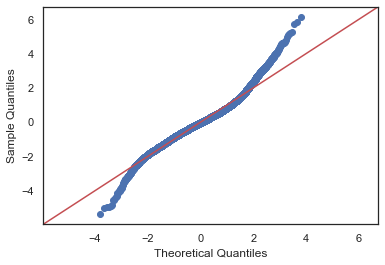

In [663]:
# Check the Normality Assumption
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

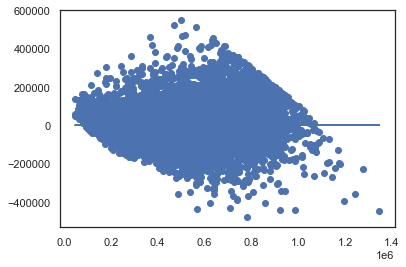

In [664]:
# Check the Homoscedasticity Assumption
# Comment: No improvement observed
plt.scatter(model.predict(train[x_cols]), model.resid)
plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])

## Ensuring Model Fit